<a href="https://colab.research.google.com/github/LC1332/Luotuo-Chinese-LLM/blob/main/notebook/MMC4clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 对于MMC4清理工作

话说从hf上下载LAION让我非常头秃，我发现MMC4的组织更干净一些

让我们来下载看一看

建立一个MMC4的下载脚本

+ 每个iter下载10个文件，
+ 对里面高similairty的进行抽取、排序，留下每个文件1万
+ 留下similarity，url, caption字段
+ 保存成一个新的文件

这样我们对这个数据集进行翻译后，可以做自学习或者是text only的学习

In [1]:
# a dataset organized as following link
# https://storage.googleapis.com/ai2-jackh-mmc4-public/data/docs_no_face_shard_{$SHARD}_v2.jsonl.zip
# where SHARD can vary from 0 to 23098.

# import a python program try download first 20 file and save into /content/temp
import os
import urllib.request
import zipfile
import json

# create temp directory if it doesn't exist
if not os.path.exists("temp"):
    os.makedirs("temp")


save_folder = '/content/save'

# check save_folder and if not exist create it
if not os.path.exists(save_folder):
    os.makedirs(save_folder)


# download and extract first 20 shards

start_index = 0
end_index = 10

max_share = 23098

def download_and_extract(start_index, end_index):
    datas = []

    print('{} to {} start job'.format(start_index, end_index))

    missing_shards = [3218,3267,5064,5146,7119,8991,9750,11899,15127,15252,16996,17369,17499,17818]

    for shard in range(start_index, end_index):

        if shard in missing_shards:
            continue

        if shard > max_share:
            break
        
        url = f"https://storage.googleapis.com/ai2-jackh-mmc4-public/data/docs_no_face_shard_{shard}_v2.jsonl.zip"
        filename = f"temp/docs_no_face_shard_{shard}_v2.jsonl.zip"
        urllib.request.urlretrieve(url, filename)
        
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall("temp")

        # jsonl named same as zip file like docs_no_face_shard_{shard}_v2.jsonl, append all jsonl into data
        with open(f"temp/docs_no_face_shard_{shard}_v2.jsonl", "r") as f:
            for line in f:
                json_format = json.loads(line)
                datas.append(json_format)

    saved_data = []

    for data in datas:
        # data organized like [{'image_name': '3dfe7f1b8889.jpg', 'raw_url': 'https://www.acornishmum.com/wp-content/uploads/2018/10/light-681540_640.jpg', 'matched_text_index': 3, 'matched_sim': 0.18006281554698944}, {'image_name': '63ebb64fea64.jpg', 'raw_url': 'https://www.acornishmum.com/wp-content/uploads/2018/08/tools-15539_640.jpg', 'matched_text_index': 1, 'matched_sim': 0.21386536955833435}, {'image_name': 'da29310f2040.jpg', 'raw_url': 'https://www.acornishmum.com/wp-content/uploads/2018/05/Vouchercloud-summer-ready.jpg', 'matched_text_index': 2, 'matched_sim': 0.29001814126968384}, {'image_name': '8ef4a00d9e7c.jpg', 'raw_url': 'https://www.acornishmum.com/wp-content/uploads/2018/03/KindnessonSocial-Media.jpg', 'matched_text_index': 7, 'matched_sim': 0.22565722465515137}, {'image_name': '275fa8a92ec7.png', 'raw_url': 'https://www.acornishmum.com/wp-content/uploads/2018/03/Bloggers-Random.png', 'matched_text_index': 8, 'matched_sim': 0.19497966766357422}, {'image_name': 'd1a15d0b3c3b.jpg', 'raw_url': 'https://www.acornishmum.com/wp-content/uploads/2018/06/You-Will-Never-Be-Everyones-Cup-of-Teaand.jpg', 'matched_text_index': 4, 'matched_sim': 0.33313706517219543}, {'image_name': '76b7018f1332.jpg', 'raw_url': 'https://www.acornishmum.com/wp-content/uploads/2018/02/dice-18208_1280.jpg', 'matched_text_index': 9, 'matched_sim': 0.22152987122535706}, {'image_name': '15ea30341800.jpg', 'raw_url': 'https://www.acornishmum.com/wp-content/uploads/2018/09/danger-of-believing.jpg', 'matched_text_index': 0, 'matched_sim': 0.20117005705833435}]
        text_list = data['text_list']
        sim_list = data['similarity_matrix']
        img_infos = data['image_info']

        # from image_info get image_name and raw_url and using matched_text_index to get text
        for img_info in img_infos:
            image_name = img_info['image_name']
            raw_url = img_info['raw_url']
            matched_text_index = img_info['matched_text_index']
            matched_sim = img_info['matched_sim']
            text = text_list[matched_text_index]
            saved_data.append({'image_name': image_name, 'url': raw_url, 'caption': text, 'sim': matched_sim})

    print('{} to {} append all data'.format(start_index, end_index))

    # sort saved_data by sim in descending order
    saved_data.sort(key=lambda x: x['sim'], reverse=True)

    # keep only the top 10000 elements with largest sim values
    saved_data = saved_data[:10000]

    # organize save_name like /content/save/saved_data_{start_index}_{end_index}.jsonl
    save_name = f"{save_folder}/saved_data_{start_index}_{end_index}.jsonl"

    # save saved_data into jsonl file
    with open(save_name, "w") as f:
        for data in saved_data:
            json.dump(data, f)
            f.write("\n")

    print('{} to {} done'.format(start_index, end_index))


尝试一下多线程

In [2]:
import multiprocessing

# compute max_n from max_share
if max_share %10 == 0:
    max_n = max_share
else:
    max_n = (1 + max_share//10)*10

pool = multiprocessing.Pool(6)
for i in range(0, max_n, 10):
    start = i
    end = i + 10
    pool.apply_async(download_and_extract, args=(start, end))
pool.close()
pool.join()

40 to 50 start job30 to 40 start job10 to 20 start job0 to 10 start job
20 to 30 start job



50 to 60 start job
0 to 10 append all data
0 to 10 done
60 to 70 start job
10 to 20 append all data
10 to 20 done
70 to 80 start job
50 to 60 append all data
30 to 40 append all data
40 to 50 append all data
30 to 40 done
20 to 30 append all data
50 to 60 done
80 to 90 start job
40 to 50 done
90 to 100 start job
20 to 30 done
100 to 110 start job
110 to 120 start job
60 to 70 append all data
60 to 70 done
70 to 80 append all data
110 to 120 append all data
70 to 80 done
90 to 100 append all data
100 to 110 append all data
80 to 90 append all data
110 to 120 done
90 to 100 done

100 to 110 done80 to 90 done


## Source

这里我们可以去考虑Hugging Face上面的LAION 2B

https://huggingface.co/datasets/laion/laion2b-multi-vit-l-14-embeddings/tree/main

而且居然有一个菩萨大神已经求了所有图片的embedding

另一方面是可以去考虑

https://github.com/allenai/mmc4



## 要收集哪些数据

另一方面我们要去考虑的是，要收集哪些数据。其实这里我们希望以CLIP-vit-l-14的词表为例子

如果词表上有一个input已经累积了很多数据，我们就不再考虑增加新的数据了

这样感觉更为合理一些，特别是对于我们初期这种小水管的训练来说

所以这个文档的第一步，我们先来分析VIT-l-14的词表

从这个链接可以看到 vit-l-14 这个模型的用法

https://huggingface.co/openai/clip-vit-large-patch14

让我们先跑上最基础的测试代码

In [ ]:
!pip install transformers
!pip install datasets

In [ ]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

# inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

# outputs = model(**inputs)
# logits_per_image = outputs.logits_per_image # this is the image-text similarity score
# probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


当然我们后期可能是真的回去要到完整的CLIP模型的

但是我们在初步我们要的是CLIP的tokenizer

你会发现其实这个tokenizer是存储在processor里面的


In [ ]:
print(processor)

CLIPProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

- tokenizer: CLIPTokenizerFast(name_or_path='openai/clip-vit-large-patch14', vocab_size=49408, model_max_length=77, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedTok

In [ ]:
from transformers import CLIPTokenizer

tokenizer = processor.tokenizer

input = tokenizer.tokenize("a dog is runing")

我们来测试一下这个tokenize的运行时间

已知 某个tokenizer可以使用 input = tokenizer.tokenize( string ) 来进行调用。设计10个英文句子，对这10个句子进行tokenize，并测量平均每次的运行时间

In [ ]:
sentences = ["I love Python.", "Python is a great language.", "This is a cat.", 
             "There are many schools in this area.", "The sky is blue.",
             "Mary is a bright student.", "The book is on the table.", 
             "He likes to play football.", "She is a doctor.",
             "The food at this restaurant is delicious."]

import time

total_time = 0
num_sentences = len( sentences )

# 对10个句子进行tokenize，并测量平均每次的运行时间
for sentence in sentences:
  start_time = time.time()
  input = tokenizer.tokenize(sentence)
  end_time = time.time()
  total_time += (end_time - start_time)

avg_time = total_time / num_sentences
print("平均运行时间： %.5f 秒" % avg_time)

平均运行时间： 0.00033 秒


这里我在T4的机器下平均运行时间是  0.00016 秒 ， 让我们来关一下GPU，重新运行一次看看。 是0.00033秒。

看来在tokenizer这一步，是否使用GPU是不要紧的。

因为我们之前已经翻译了coco captioning，让我们来载入coco captioning，来统计一下不同token的出现频率。



In [ ]:
from datasets import load_dataset

dataset = load_dataset("ChristophSchuhmann/MS_COCO_2017_URL_TEXT")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/ChristophSchuhmann___parquet/ChristophSchuhmann--MS_COCO_2017_URL_TEXT-01533eba737b92f6/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
n_coco =  len( dataset['train']) 

print(n_coco)

591753


In [ ]:
for i in range(n_coco):
  text = dataset['train'][i]['TEXT']
  token = tokenizer.tokenize( text )
  print(text)
  print(token)

  if i > 5:
    break

A man with a red helmet on a small moped on a dirt road. 
['a</w>', 'man</w>', 'with</w>', 'a</w>', 'red</w>', 'helmet</w>', 'on</w>', 'a</w>', 'small</w>', 'mo', 'ped</w>', 'on</w>', 'a</w>', 'dirt</w>', 'road</w>', '.</w>']
Man riding a motor bike on a dirt road on the countryside.
['man</w>', 'riding</w>', 'a</w>', 'motor</w>', 'bike</w>', 'on</w>', 'a</w>', 'dirt</w>', 'road</w>', 'on</w>', 'the</w>', 'countryside</w>', '.</w>']
A man riding on the back of a motorcycle.
['a</w>', 'man</w>', 'riding</w>', 'on</w>', 'the</w>', 'back</w>', 'of</w>', 'a</w>', 'motorcycle</w>', '.</w>']
A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. 
['a</w>', 'dirt</w>', 'path</w>', 'with</w>', 'a</w>', 'young</w>', 'person</w>', 'on</w>', 'a</w>', 'motor</w>', 'bike</w>', 'rests</w>', 'to</w>', 'the</w>', 'foreground</w>', 'of</w>', 'a</w>', 'ver', 'dant</w>', 'area</w>', 'with</w>', 'a</w>', 'bridge

我们看看有没有办法做一个多线程的统计，先取出前1000个元素吧


In [ ]:

demo_list = []

for i in range(0,10000):
  text = dataset['train'][i]['TEXT']
  token = tokenizer.tokenize( text )
  demo_list.append( token )

给定一个Python的list of 字符串list，my_strs 其中比如my_strs[0] = ['a</w>', 'man</w>', 'with</w>', 'a</w>', 'red</w>', 'helmet</w>', 'on</w>', 'a</w>', 'small</w>', 'mo', 'ped</w>', 'on</w>', 'a</w>', 'dirt</w>', 'road</w>', '.</w>']

my_strs[1] = ['man</w>', 'riding</w>', 'a</w>', 'motor</w>', 'bike</w>', 'on</w>', 'a</w>', 'dirt</w>', 'road</w>', 'on</w>', 'the</w>', 'countryside</w>', '.</w>']

实现一段python函数，统计my_strs中，不同字符串的出现频率。使用多线程。


In [ ]:
from collections import Counter
from concurrent.futures import ThreadPoolExecutor

my_strs = demo_list

def count_frequency(lst):
    return Counter(lst)

with ThreadPoolExecutor(max_workers=16) as executor:
    results = list(executor.map(count_frequency, my_strs))
# 合并所有线程的结果
final_result = sum(results, Counter())
# 打印每个元素及对应的频次

In [ ]:
# 根据字典的value值进行排序
sorted_words = sorted(final_result.items(), key=lambda item: item[1], reverse=True)

# 取前10个元素
top_10_words = sorted_words[-10:]

# 打印输出
for i, word in enumerate(top_10_words):
    print(f"{i+1}. {word[0]}: {word[1]}")

1. sai</w>: 1
2. guide</w>: 1
3. entitled</w>: 1
4. ral</w>: 1
5. run: 1
6. lamb</w>: 1
7. snap</w>: 1
8. mad</w>: 1
9. vista</w>: 1
10. stormy</w>: 1


那我们来写一下完整的代码

In [ ]:
from datasets import load_dataset
from tqdm.asyncio import tqdm as tqdm

dataset = load_dataset("ChristophSchuhmann/MS_COCO_2017_URL_TEXT")

n_coco =  len( dataset['train']) 

print(n_coco)

demo_list = []

for i in tqdm(range(0,n_coco), total = n_coco, desc = 'move into list'):
  text = dataset['train'][i]['TEXT']
  token = tokenizer.tokenize( text )
  demo_list.append( token )

  0%|          | 0/1 [00:00<?, ?it/s]

591753


move into list: 100%|██████████| 591753/591753 [02:48<00:00, 3516.38it/s]


In [ ]:
from collections import Counter
from concurrent.futures import ThreadPoolExecutor

def count_frequency(lst):
    return Counter(lst)

with ThreadPoolExecutor(max_workers=16) as executor:
    results = list(executor.map(count_frequency, demo_list))
# 合并所有线程的结果
final_result = sum(results, Counter())
# 打印每个元素及对应的频次

In [ ]:
print(len(results))
print(results[0])

591753
Counter({'a</w>': 4, 'on</w>': 2, 'man</w>': 1, 'with</w>': 1, 'red</w>': 1, 'helmet</w>': 1, 'small</w>': 1, 'mo': 1, 'ped</w>': 1, 'dirt</w>': 1, 'road</w>': 1, '.</w>': 1})


In [ ]:
n = len(results)

batch_size = 1000
n_batch = int(n // batch_size) + 1

sub_counter = []

for i in tqdm(range(0,n_batch), total = n_batch, desc = 'counter in batch'):
  y = min(n-1,(i+1)*batch_size)
  sub_counter.append( sum(results[ i*batch_size : y ], Counter()) )

counter in batch: 100%|██████████| 592/592 [03:29<00:00,  2.83it/s]


In [ ]:
coco_train_freq = sum( sub_counter ,  Counter() )

In [ ]:
# 根据字典的value值进行排序
sorted_words = sorted(coco_train_freq.items(), key=lambda item: item[1], reverse=True)

print(len(sorted_words), ' words found in coco')

# 取前10个元素
top_10_words = sorted_words[:10]

# 打印输出
for i, word in enumerate(top_10_words):
    print(f"{i+1}. {word[0]}: {word[1]} {word[1]/n_coco * 100}%")

19278  words found in coco
1. a</w>: 978851 165.41546895410755%
2. .</w>: 444432 75.10430872340318%
3. on</w>: 215754 36.46014468874682%
4. of</w>: 204089 34.488883030588774%
5. the</w>: 197831 33.43134720060566%
6. in</w>: 184211 31.12971121396934%
7. with</w>: 154817 26.162436016378454%
8. and</w>: 140931 23.815848842337935%
9. is</w>: 98445 16.636164075213813%
10. man</w>: 73372 12.399092188801747%


我感觉GPT老师给我的不是一个很高效的实现。。不过也先这样吧。。

我做了一个分batch reduce 然后再reduce

跑完了我们来保存一下。。。

In [ ]:
import pickle

with open("coco_train_freq.pkl", "wb") as f:
    pickle.dump(coco_train_freq, f)

## 从新数据集上寻找词表中没有的词


我们先重开一下机器吧

接下来让我们试试看载入LAION

In [ ]:
!pip install transformers
!pip install datasets

In [ ]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

In [ ]:
tokenizer = processor.tokenizer

In [ ]:
import pickle

with open("coco_train_freq.pkl", "rb") as f:
    coco_train_freq = pickle.load(f)

print(coco_train_freq)

coco_train_freq 是一个python的Counter， 如 Counter({'a</w>': 978851, '.</w>': 444432, 'on</w>': 215754, 'of</w>': 204089, 'the</w>': 197831） 将coco_train_freq转化为一个value为float的字典

In [ ]:
coco_train_freq_float = {}

for k, v in coco_train_freq.items():
    coco_train_freq_float[k] = float(v)

print(coco_train_freq_float)

LAION的数据集都太大了，我们先来拿一个HD subset的过来玩一下吧。。。


In [ ]:
from datasets import load_dataset

dataset = load_dataset("yuvalkirstain/laion-hd-subset")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/13451 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1495 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/yuvalkirstain___parquet/yuvalkirstain--laion-hd-subset-85e1d0189a20fe06/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

laion是真的屌，光json的part就2.7G然后有几十个part。。。那算了我们先玩一下400M的子集吧

In [ ]:
print(dataset['train'][0])

{'similarity': 0.2643807530403137, 'hash': 8441708930180998904, 'punsafe': 0.00017464160919189453, 'pwatermark': 0.009912466630339622, 'LANGUAGE': 'sw', 'caption': 'Odisha - 2 : Simlipal', 'url': 'https://img.over-blog-kiwi.com/0/99/16/03/20190110/ob_987ce2_dsc03556.jpg', 'key': '000004145', 'status': 'success', 'error_message': None, 'width': 1024, 'height': 1024, 'original_width': 1600, 'original_height': 1600, 'exif': '{}', 'md5': 'e372d63f46ab5956eb7e5b46cfc3b558', 'path': 'laion-high-resolution-output/00000/000004145.jpg', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x1024 at 0x7F2FA0F03AF0>}


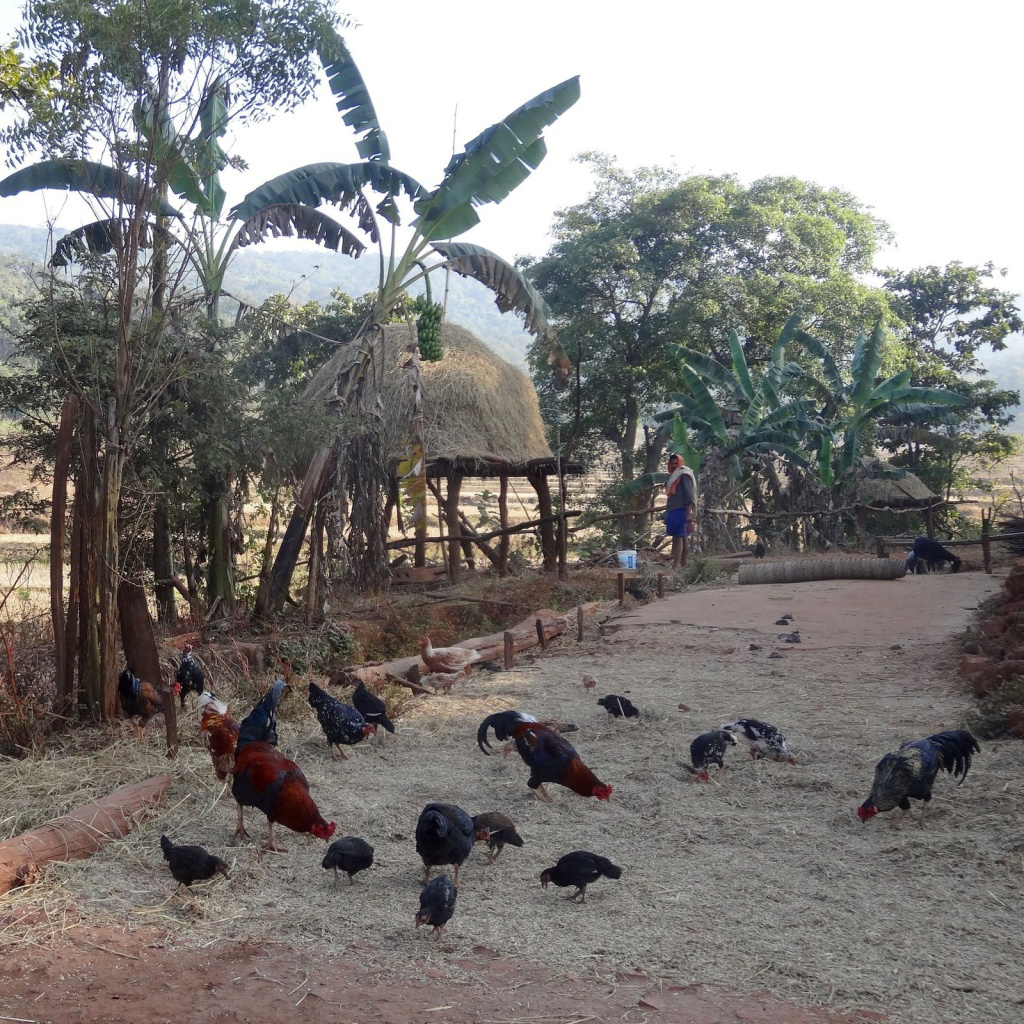

In [ ]:
dataset['train'][0]['image']

我说怎么那么大呢。。。带了个图啊。。。

还是让我们专注词表吧。。

In [ ]:
n_laion = len(dataset['train'])

print('size = ', n_laion)

size =  13451


In [ ]:
print(dataset['train'][0])
print(dataset['train'][0]['similarity'])
print(dataset['train'][0]['LANGUAGE'])
print(dataset['train'][0]['caption'])


{'similarity': 0.2643807530403137, 'hash': 8441708930180998904, 'punsafe': 0.00017464160919189453, 'pwatermark': 0.009912466630339622, 'LANGUAGE': 'sw', 'caption': 'Odisha - 2 : Simlipal', 'url': 'https://img.over-blog-kiwi.com/0/99/16/03/20190110/ob_987ce2_dsc03556.jpg', 'key': '000004145', 'status': 'success', 'error_message': None, 'width': 1024, 'height': 1024, 'original_width': 1600, 'original_height': 1600, 'exif': '{}', 'md5': 'e372d63f46ab5956eb7e5b46cfc3b558', 'path': 'laion-high-resolution-output/00000/000004145.jpg', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x1024 at 0x7F2FB9AA4580>}
0.2643807530403137
sw
Odisha - 2 : Simlipal


先给出基本代码

In [ ]:
for i in range(0, n_laion):
  if dataset['train'][i]['LANGUAGE'] != 'en':
    continue
  caption_text = dataset['train'][i]['caption']
  print(caption_text)
  break

Page 15


带入词表

In [ ]:
for i in range(0, n_laion):
  if dataset['train'][i]['LANGUAGE'] != 'en':
    continue
  caption_text = dataset['train'][i]['caption']
  token = tokenizer.tokenize( caption_text )

  print(caption_text)
  print(token)
  break


Page 15
['page</w>', '1</w>', '5</w>']


给定一个dictionary, coco_train_freq_float

{'a</w>': 978851.0, 'man</w>': 73372.0,'with</w>': 154817}

再给定一个list

token = ['page</w>', '1</w>', '5</w>']

逐个判断token中的元素在不在coco_train_freq_float中，如果不在则打印token中的元素，如果在 则打印coco_train_freq_float中对应的频率

In [ ]:
found_count = 0

for i in range(0, n_laion):
  if dataset['train'][i]['LANGUAGE'] != 'en':
    continue
  caption_text = dataset['train'][i]['caption']
  token = tokenizer.tokenize( caption_text )

  # print(caption_text)
  # print(token)

  for t in token:
    frequency = coco_train_freq_float.get(t, None)
    if frequency is None:
        found_count = found_count + 1
        print('发现第' , found_count ,'个新词',  t ,' with id = ',i, ' in ',caption_text )
        
    else:
        pass
  if found_count > 50:
    break


发现第 1 个新词 fanatics</w>  with id =  5  in  Men's Fanatics Branded Orange Florida Gators Personalized Basketball Pullover Hoodie 3
发现第 2 个新词 happ  with id =  6  in  Happee Birthdae 3x4 Stamp Set
发现第 3 个新词 birth  with id =  6  in  Happee Birthdae 3x4 Stamp Set
发现第 4 个新词 Â©</w>  with id =  10  in  How To Pick Up A Motorcycle © Brake Magazine 2017
发现第 5 个新词 vince</w>  with id =  18  in  Alternate Image 2  - Vince Camuto Colorblock Houndstooth Blazer
发现第 6 个新词 uto</w>  with id =  18  in  Alternate Image 2  - Vince Camuto Colorblock Houndstooth Blazer
发现第 7 个新词 hound  with id =  18  in  Alternate Image 2  - Vince Camuto Colorblock Houndstooth Blazer
发现第 8 个新词 ooth</w>  with id =  18  in  Alternate Image 2  - Vince Camuto Colorblock Houndstooth Blazer
发现第 9 个新词 brand  with id =  19  in  a floodlit view of the brandenburg gate at night
发现第 10 个新词 ffey</w>  with id =  20  in  The Custom House and The Liffey
发现第 11 个新词 middleton</w>  with id =  25  in  Residence Inn Madison WestMiddleton  Marriot

每一个词 都有top5的图片记录

每次对于一张新的图片

如果这张图片中有新的词（按过往记录频率最低为记）

那么就把这张图片记录为这个词所属的图


如果这张图中没有任何新词（出现的所有token都已经大于5张，则会比较每个token top5图片的最小的那个simiarlity，如果当前图片大于5th，则发生一次swap）

sawp过程，将当前图片存成目标词的5th，

对于drop掉的图片，重新检查一次新词

反复第二步

{'row_idx': 0, 'row': {'image_path': '185120009', 'caption': 'Color version PULP FICTION alternative poster art', 'NSFW': 'UNLIKELY', 'similarity': 0.33966901898384094, 'LICENSE': '?', 'url': 'http://cdn.shopify.com/s/files/1/0282/0804/products/pulp_1024x1024.jpg?v=1474264437', 'key': '185120009', 'status': 'success', 'error_message': None, 'width': 384, 'height': 512, 'original_width': 768, 'original_height': 1024, 'exif': '{"Image Orientation": "Horizontal (normal)", "Image XResolution": "100", "Image YResolution": "100", "Image ResolutionUnit": "Pixels/Inch", "Image YCbCrPositioning": "Centered", "Image ExifOffset": "102", "EXIF ExifVersion": "0210", "EXIF ComponentsConfiguration": "YCbCr", "EXIF FlashPixVersion": "0100", "EXIF ColorSpace": "Uncalibrated", "EXIF ExifImageWidth": "768", "EXIF ExifImageLength": "1024"}', 'md5': '46c4bbab739a2b71639fb5a3a4035b36'}, 'truncated_cells': []}

In [ ]:
!wget https://storage.googleapis.com/ai2-jackh-mmc4-public/data/docs_no_face_shard_0_v2.jsonl.zip

--2023-05-14 10:00:07--  https://storage.googleapis.com/ai2-jackh-mmc4-public/data/docs_no_face_shard_0_v2.jsonl.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.250.31.128, 142.251.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8473269 (8.1M) [application/zip]
Saving to: ‘docs_no_face_shard_0_v2.jsonl.zip’

docs_no_face_shard_ 100%[===================>]   8.08M  --.-KB/s    in 0.1s    

2023-05-14 10:00:08 (68.0 MB/s) - ‘docs_no_face_shard_0_v2.jsonl.zip’ saved [8473269/8473269]



In [ ]:
!unzip /content/docs_no_face_shard_0_v2.jsonl.zip -d /content
# !unzip /content/temp-20230512T220424Z-002.zip -d /content/temp

Archive:  /content/docs_no_face_shard_0_v2.jsonl.zip
replace /content/docs_no_face_shard_0_v2.jsonl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/docs_no_face_shard_0_v2.jsonl  


In [ ]:
import json

datas = []

with open('/content/docs_no_face_shard_0_v2.jsonl', 'r') as f:
    for line in f:
        item = json.loads(line.strip())
        datas.append(item)

In [ ]:
n_data = len( datas )

saved_text = []

for data in datas:
  text_list = data['text_list']
  sim_list = data['similarity_matrix']

  for current_array in sim_list:
    score = max(current_array)
    max_index = current_array.index(score)
    saved_text.append( (score,text_list[max_index] ))

有一个python数组类似如下 [(0.3148163855075836, 'So how much does a record-breaking lensing galaxy weigh?'), (0.1953807771205902, 'But let’s not.')] 利用每个元素的第一个数字进行降序排序

In [ ]:
saved_text = sorted(saved_text, key=lambda x: x[0], reverse=True)

In [ ]:
for i in range(10):
  print(saved_text[i][1],' ', saved_text[i][0])

I read with interest that Olympus Malaysia is holding a Pre-Order Promotion for the new OM-D EM-5 camera.   0.4365123510360718
In 1979, the Philippines issued an attractive set of stamps featuring Native Birds (Scott #1392-97).   0.43108057975769043
This year, Oregon State University’s College of Education’s Counseling program is proud to announce the celebration of its 100th anniversary.   0.4309481978416443
This farm scavenger printable includes a cow, cat, pig, dog, sheep, goat, goose, horse, and chicken.   0.42962828278541565
After much research and pitch, finally the name "Libaas Couture" was chosen to be the brand name.   0.4266972839832306
inah omoronyia and tor stålhane requirements specification and testing an introduction.   0.423553466796875
Control Point is the debut novel of Myke Cole, and the first in a series of “Shadow Ops” novels (of which there are three, with a prequel due out next year).   0.4224153161048889
David Kaye’s The Double Helix and the Law of Evidence is a

这个实验先做到这里

可以使用每个包前 n_data/ 2的数据保留 这样总体会留下非常多数据

In [ ]:
print(data[2]['similarity_matrix'])

[[0.28204163908958435, 0.15614458918571472, 0.174833744764328, 0.2311287373304367, 0.26510486006736755], [0.2898246943950653, 0.16946707665920258, 0.18884825706481934, 0.21569928526878357, 0.31874263286590576]]


In [ ]:
print(data[2]['text_list'])

['Perfect for exhibitions, displays, or advertising in small spaces.', 'Do You Have Your Artwork?', 'Please upload your artwork as a pdf print ready file.', 'Includes Hardware, printed banner, and carry case.', 'Available with digitally printed ‘premium’* 165 micron grey-backed polyester film banners.']
